In [ ]:
import zipfile
import os

zip_file = '/content/Detection of PCOS - Object Detection.v4i.yolov8.zip'
unzip_dir = '/content/PCOS'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

os.listdir(unzip_dir)


['valid',
 'test',
 'README.dataset.txt',
 'train',
 'data.yaml',
 'README.roboflow.txt']

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from ultralytics import YOLO
import torch
import os
import cv2
import matplotlib.pyplot as plt
import glob

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
import glob
import numpy as np

def augment_image_and_labels(image_path, label_path, save_dir_images, save_dir_labels, num_augmentations=3):
    """
    Applies data augmentation to an image and its corresponding YOLO bounding box labels, then saves them.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load bounding boxes in YOLO format (x_center, y_center, width, height normalized)
    height, width, _ = image.shape
    with open(label_path, "r") as f:
        bboxes = []
        class_labels = []
        for line in f.readlines():
            values = line.strip().split()
            class_labels.append(int(values[0]))
            x_center, y_center, bbox_width, bbox_height = map(float, values[1:])
            bboxes.append([x_center, y_center, bbox_width, bbox_height])  # Keep YOLO format

    # Define Augmentations
    augmentations = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.Rotate(limit=30, p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.GaussNoise(var_limit=(10, 50), p=0.3),
        A.RandomCrop(height=640, width=640, p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))  # 🔹 Keep format='yolo'

    for i in range(num_augmentations):
        augmented = augmentations(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_image = (augmented["image"].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)  # Convert to OpenCV format
        new_image_name = f"{os.path.basename(image_path).split('.')[0]}_aug_{i}.jpg"
        save_path_img = os.path.join(save_dir_images, new_image_name)
        cv2.imwrite(save_path_img, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

        # Save augmented labels in YOLO format
        new_label_name = new_image_name.replace(".jpg", ".txt")
        save_path_label = os.path.join(save_dir_labels, new_label_name)
        with open(save_path_label, "w") as f:
            for bbox, cls in zip(augmented['bboxes'], augmented['class_labels']):
                x_center, y_center, bbox_width, bbox_height = bbox
                f.write(f"{cls} {x_center} {y_center} {bbox_width} {bbox_height}\n")  # Keep YOLO format



In [ ]:

# Paths
data_dir_images = "/content/PCOS/train/images"
data_dir_labels = "/content/PCOS/train/labels"
augmented_dir_images = "/content/PCOS/train/images_aug"  # Separate directory
augmented_dir_labels = "/content/PCOS/train/labels_aug"  # Separate directory

# Create directories if not exist
os.makedirs(augmented_dir_images, exist_ok=True)
os.makedirs(augmented_dir_labels, exist_ok=True)

# Get image paths
image_paths = glob.glob(os.path.join(data_dir_images, "*.jpg"))

# Process each image
for img_path in image_paths:
    label_path = img_path.replace("/images/", "/labels/").replace(".jpg", ".txt")
    if os.path.exists(label_path):
        augment_image_and_labels(img_path, label_path, augmented_dir_images, augmented_dir_labels, num_augmentations=3)

print(f"\n✅ Augmentation completed. Augmented images saved in {augmented_dir_images}, labels in {augmented_dir_labels}")



<ipython-input-6-48a50fa367c5>:33: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.3),



✅ Augmentation completed. Augmented images saved in /content/PCOS/train/images_aug, labels in /content/PCOS/train/labels_aug


In [ ]:
# Count images correctly
original_images = glob.glob(os.path.join(data_dir_images, "*.jpg"))
augmented_images = glob.glob(os.path.join(augmented_dir_images, "*.jpg"))

num_original = len(original_images)
num_augmented = len(augmented_images)
total_images = num_original + num_augmented

print(f"Original images: {num_original}")
print(f"Augmented images: {num_augmented}")
print(f"Total images after augmentation: {total_images}")


Original images: 958
Augmented images: 2769
Total images after augmentation: 3727


In [ ]:
data_yaml = '/content/PCOS/data.yaml'

In [ ]:
model = YOLO('yolov8x.pt')

100%|██████████| 131M/131M [00:00<00:00, 229MB/s]


In [ ]:
model.train(
    data=data_yaml,
    task='detect',
    imgsz=640,
    epochs=25,
    batch=8,
    optimizer='Adam',
    lr0=0.001,
    weight_decay=0.0005,
    patience=10,
    val=True,
    device=device,
    name='yolov8_pcos',
    exist_ok=True
)

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/PCOS/data.yaml, epochs=25, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=yolov8_pcos, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

100%|██████████| 755k/755k [00:00<00:00, 39.7MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 168MB/s]


AMP: checks passed ✅


train: Scanning /content/PCOS/train/labels... 958 images, 0 backgrounds, 0 corrupt: 100%|██████████| 958/958 [00:00<00:00, 2086.66it/s]

train: New cache created: /content/PCOS/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/PCOS/valid/labels... 138 images, 0 backgrounds, 0 corrupt: 100%|██████████| 138/138 [00:00<00:00, 552.55it/s]

val: New cache created: /content/PCOS/valid/labels.cache


Plotting labels to runs/detect/yolov8_pcos/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8_pcos
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      7.09G     0.2574     0.7641      1.005         16        640: 100%|██████████| 120/120 [01:18<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]

                   all        138        138       0.72      0.836      0.805      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      8.09G     0.2489     0.5065     0.9767         20        640: 100%|██████████| 120/120 [01:17<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.03it/s]

                   all        138        138      0.688      0.874      0.826      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      8.14G     0.2299     0.4507     0.9626         16        640: 100%|██████████| 120/120 [01:17<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]

                   all        138        138      0.761      0.842      0.856       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      8.59G     0.2148     0.3857     0.9486         18        640: 100%|██████████| 120/120 [01:17<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.05it/s]

                   all        138        138      0.796      0.877       0.87       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      8.64G     0.1788     0.3541     0.9399         17        640: 100%|██████████| 120/120 [01:17<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.00it/s]

                   all        138        138      0.873      0.912      0.965       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      9.06G      0.154     0.2916     0.9265         18        640: 100%|██████████| 120/120 [01:17<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]

                   all        138        138      0.946      0.927      0.978       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      9.47G     0.1369      0.271     0.9239         19        640: 100%|██████████| 120/120 [01:16<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]

                   all        138        138      0.997          1      0.995      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      9.85G     0.1266      0.239     0.9097         24        640: 100%|██████████| 120/120 [01:16<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.05it/s]

                   all        138        138      0.978      0.981      0.989      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      10.2G     0.1249     0.2493     0.9131         22        640: 100%|██████████| 120/120 [01:16<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.04it/s]

                   all        138        138      0.986          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      10.6G     0.1183     0.2229     0.9119         16        640: 100%|██████████| 120/120 [01:16<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]

                   all        138        138      0.999          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25        11G     0.1088     0.2048     0.9021         20        640: 100%|██████████| 120/120 [01:16<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]

                   all        138        138      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.5G      0.113     0.2175     0.9011         20        640: 100%|██████████| 120/120 [01:16<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]

                   all        138        138      0.999          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.8G    0.09709     0.1938     0.9025         22        640: 100%|██████████| 120/120 [01:16<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]

                   all        138        138      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      12.2G    0.08915     0.1876     0.9039         19        640: 100%|██████████| 120/120 [01:16<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.04it/s]

                   all        138        138      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      12.6G    0.08754     0.1879      0.903         17        640: 100%|██████████| 120/120 [01:16<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]

                   all        138        138      0.999          1      0.995      0.995


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25        13G    0.06715     0.1638     0.9333          6        640: 100%|██████████| 120/120 [01:16<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.04it/s]

                   all        138        138       0.94      0.977      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      13.4G    0.06012     0.1041     0.9155          6        640: 100%|██████████| 120/120 [01:16<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.04it/s]

                   all        138        138      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      7.66G     0.0567    0.08612     0.9077          6        640: 100%|██████████| 120/120 [01:16<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]

                   all        138        138      0.999          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25       8.6G    0.05021    0.07323     0.9048          6        640: 100%|██████████| 120/120 [01:17<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.03it/s]

                   all        138        138      0.999          1      0.995      0.995
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 9, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



19 epochs completed in 0.478 hours.
Optimizer stripped from runs/detect/yolov8_pcos/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/yolov8_pcos/weights/best.pt, 136.7MB

Validating runs/detect/yolov8_pcos/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]


                   all        138        138      0.999          1      0.995      0.995
                normal         85         85      0.999          1      0.995      0.995
                  pcos         53         53      0.998          1      0.995      0.995
Speed: 0.2ms preprocess, 27.2ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/yolov8_pcos


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e3f58c895d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
# Validate the best model
best_model_path = '/content/runs/detect/yolov8_pcos/weights/best.pt'
model = YOLO(best_model_path)
metrics = model.val(data=data_yaml, split='test')

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /content/PCOS/test/labels... 267 images, 0 backgrounds, 0 corrupt: 100%|██████████| 267/267 [00:00<00:00, 655.75it/s]

val: New cache created: /content/PCOS/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]


                   all        267        267      0.996      0.995      0.992      0.992
                normal        161        161      0.993          1      0.989      0.989
                  pcos        106        106      0.999      0.991      0.995      0.995
Speed: 1.7ms preprocess, 64.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val


In [ ]:
# Load the best model
best_model_path = "/content/runs/detect/yolov8_pcos/weights/best.pt"
model = YOLO(best_model_path)

# Validate the model and get metrics
metrics = model.val(data='/content/PCOS/data.yaml', split='test')

# Extract metrics correctly
mean_precision = metrics.box.p.mean()   # Mean Precision
mean_recall = metrics.box.r.mean()      # Mean Recall
map50 = metrics.box.map50               # mAP@50
map50_90 = metrics.box.map               # mAP@50-95

# Print the results
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"mAP@50: {map50:.4f}")
print(f"mAP@50-95: {map50_90:.4f}")


Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /content/PCOS/test/labels.cache... 267 images, 0 backgrounds, 0 corrupt: 100%|██████████| 267/267 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:18<00:00,  1.07s/it]


                   all        267        267      0.996      0.995      0.992      0.992
                normal        161        161      0.993          1      0.989      0.989
                  pcos        106        106      0.999      0.991      0.995      0.995
Speed: 1.3ms preprocess, 61.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val7
Mean Precision: 0.9963
Mean Recall: 0.9953
mAP@50: 0.9921
mAP@50-95: 0.9921


In [ ]:
image_path = '/content/PCOS/valid/images/img_0_8860_jpg.rf.78d9215f6b53c7dbf200e8b92f53f0d6.jpg'
results = model.predict(source=image_path, save=False, show=False)



image 1/1 /content/PCOS/valid/images/img_0_8860_jpg.rf.78d9215f6b53c7dbf200e8b92f53f0d6.jpg: 640x640 1 pcos, 96.6ms
Speed: 6.1ms preprocess, 96.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
result_image = results[0].plot()
result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

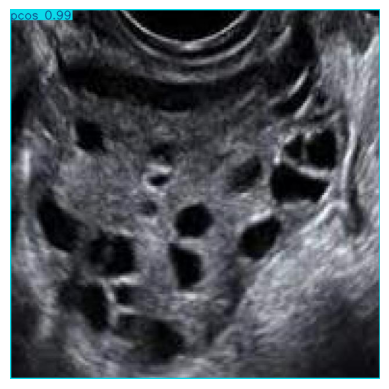

In [ ]:
plt.imshow(result_image_rgb)
plt.axis('off')
plt.show()

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /content/PCOS/test/labels.cache... 267 images, 0 backgrounds, 0 corrupt: 100%|██████████| 267/267 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:18<00:00,  1.06s/it]


                   all        267        267      0.996      0.995      0.992      0.992
                normal        161        161      0.993          1      0.989      0.989
                  pcos        106        106      0.999      0.991      0.995      0.995
Speed: 0.7ms preprocess, 61.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val15


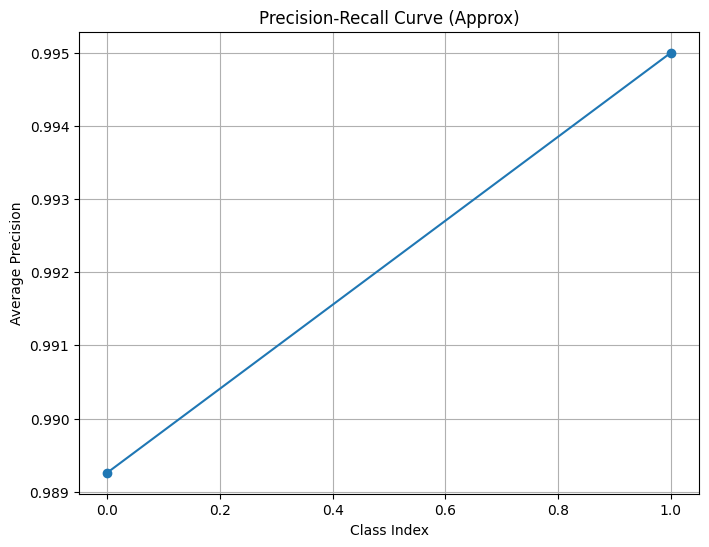


0: 640x640 1 pcos, 79.4ms
Speed: 2.1ms preprocess, 79.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


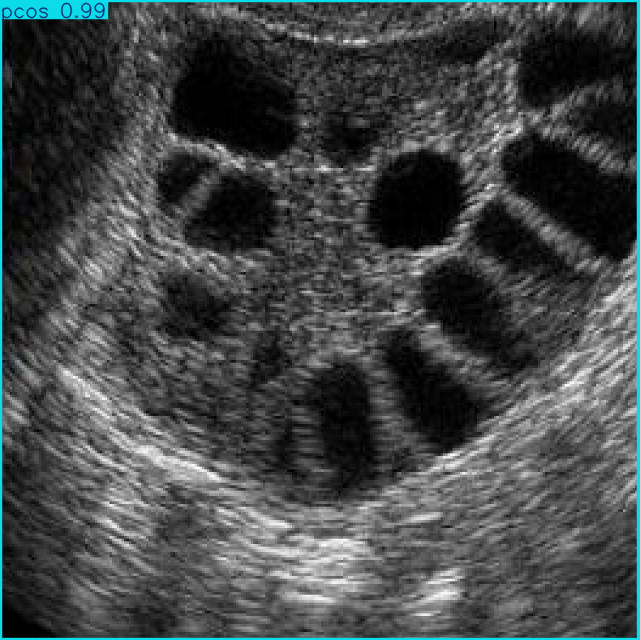


0: 640x640 1 pcos, 73.4ms
Speed: 3.5ms preprocess, 73.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


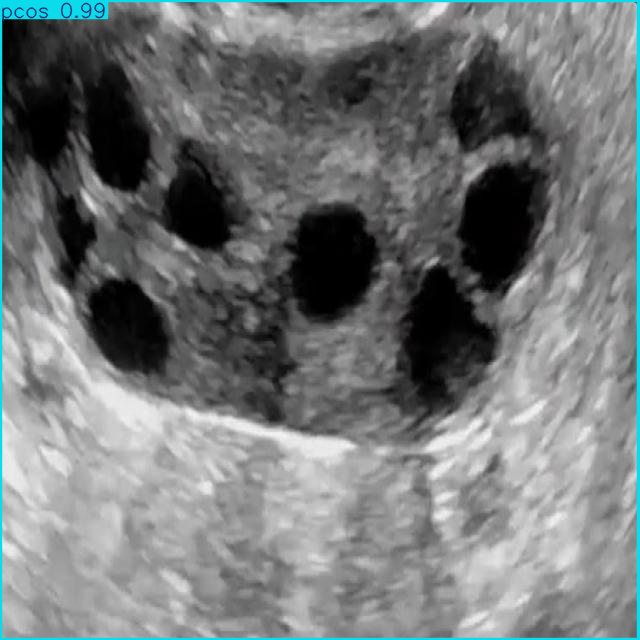


0: 640x640 1 pcos, 55.0ms
Speed: 2.7ms preprocess, 55.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


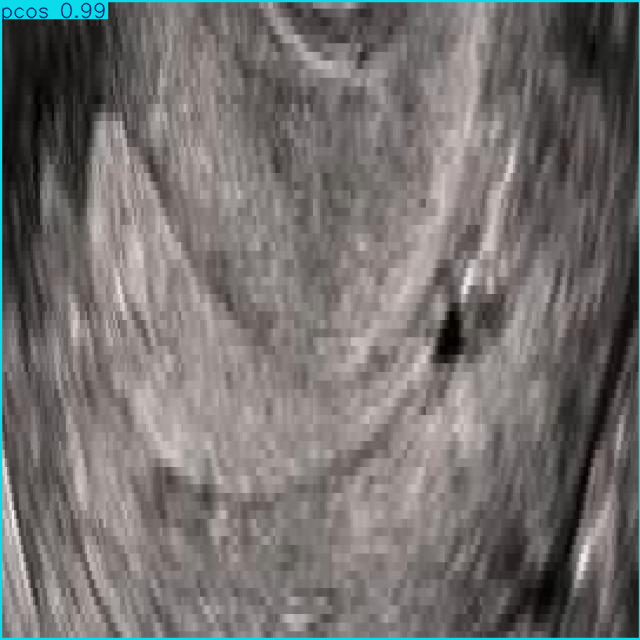


0: 640x640 1 pcos, 55.8ms
Speed: 3.0ms preprocess, 55.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


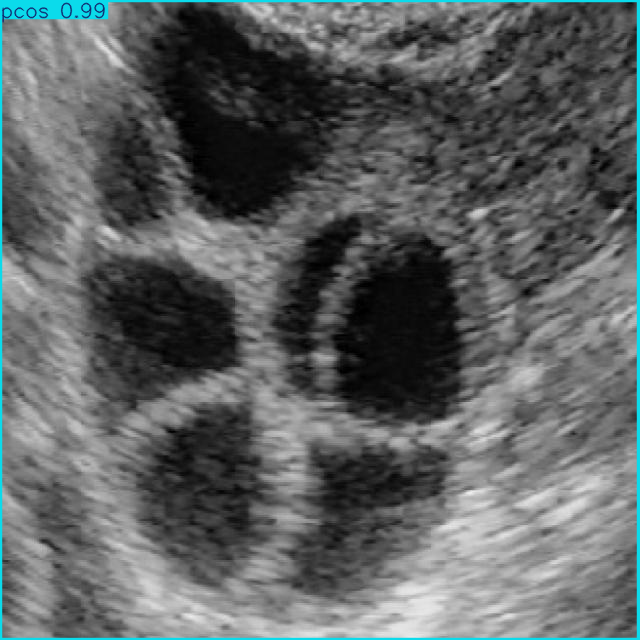


0: 640x640 1 normal, 54.9ms
Speed: 2.9ms preprocess, 54.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


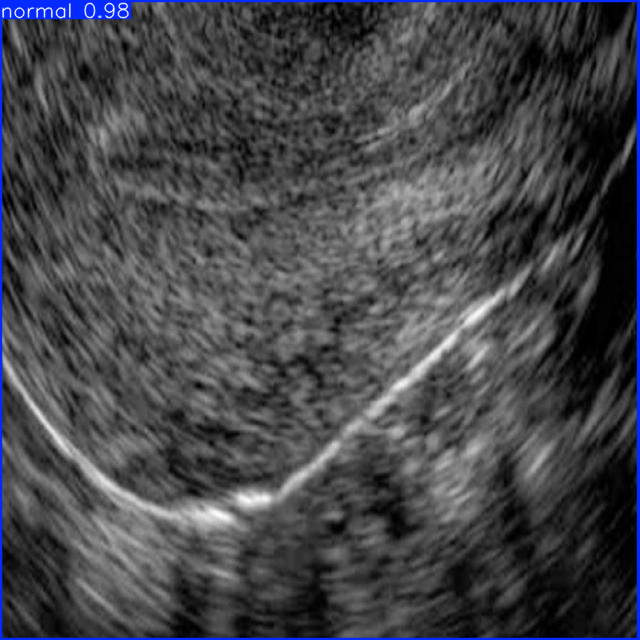

In [ ]:
import seaborn as sns

# Load the trained model
best_model_path = '/content/runs/detect/yolov8_pcos/weights/best.pt'
model = YOLO(best_model_path)

# Load validation metrics
data_yaml = '/content/PCOS/data.yaml'
metrics = model.val(data=data_yaml, split='test')

mean_precision = metrics.box.p.mean()   # Mean Precision
mean_recall = metrics.box.r.mean()      # Mean Recall
map50 = metrics.box.map50               # mAP@50
map50_90 = metrics.box.map               # mAP@50-95



conf_matrix = metrics.confusion_matrix  # No need to use ['confusion_matrix']

pr_values = np.array(metrics.box.all_ap).mean(axis=1)  # Compute mean AP for each class

plt.figure(figsize=(8, 6))
plt.plot(pr_values, marker='o', linestyle='-')
plt.xlabel('Class Index')
plt.ylabel('Average Precision')
plt.title('Precision-Recall Curve (Approx)')
plt.grid(True)
plt.show()

import cv2


test_images = glob.glob("/content/PCOS/test/images/*.jpg")[:5]  # Pick 5 random images
for img_path in test_images:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Predict using the model
    results = model(img)

    # Plot the results
    for result in results:
        result.show()



In [ ]:
from google.colab import files
files.download('/content/runs/detect/yolov8_pcos/weights/best.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load YOLOv8 model
model = YOLO("/content/runs/detect/yolov8_pcos/weights/best.pt")

# Export to ONNX
model.export(format="onnx")


Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs

PyTorch: starting from '/content/runs/detect/yolov8_pcos/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (130.4 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 145.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 282.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 169.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 304.7 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 24.3s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rer

'/content/runs/detect/yolov8_pcos/weights/best.onnx'

In [ ]:
files.download('/content/runs/detect/yolov8_pcos/weights/best.onnx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


# Load CSV
results_csv_path = "/content/runs/detect/yolov8_pcos/results.csv"
df = pd.read_csv(results_csv_path)

# Display column names
print(df.columns)


Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


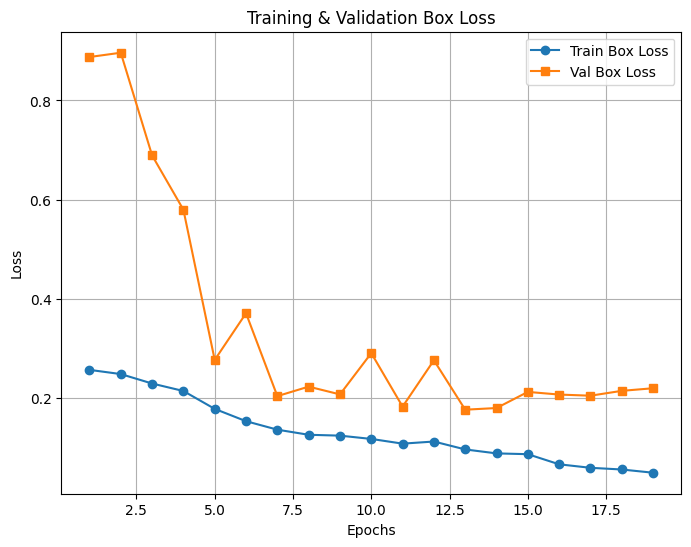

In [ ]:
results_csv_path = "/content/runs/detect/yolov8_pcos/results.csv"
df = pd.read_csv(results_csv_path)

epochs = df["epoch"]

# Loss Curves (Training vs. Validation)
plt.figure(figsize=(8, 6))
plt.plot(epochs, df["train/box_loss"], label="Train Box Loss", marker='o')
plt.plot(epochs, df["val/box_loss"], label="Val Box Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Box Loss")
plt.legend()
plt.grid(True)
plt.show()


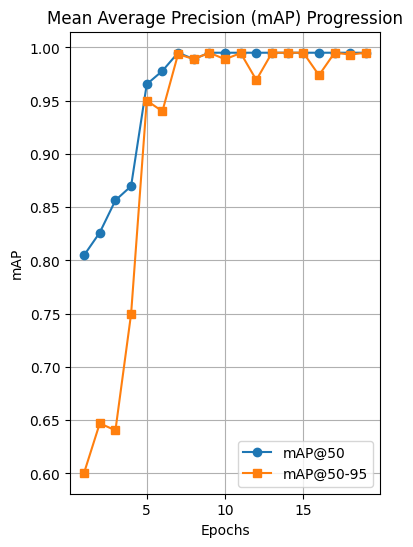

In [ ]:
# Mean Average Precision (mAP) Progression
plt.figure(figsize=(4, 6))
plt.plot(epochs, df["metrics/mAP50(B)"], label="mAP@50", marker='o')
plt.plot(epochs, df["metrics/mAP50-95(B)"], label="mAP@50-95", marker='s')
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.title("Mean Average Precision (mAP) Progression")
plt.legend()
plt.grid(True)
plt.show()


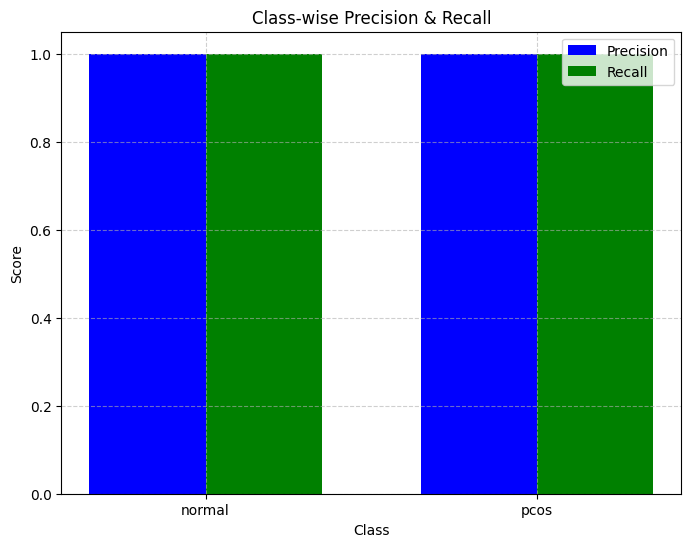

In [ ]:
#Class-wise Precision & Recall Bar Chart
class_labels = ["normal", "pcos"]  # Update if necessary

# Extract last recorded values for class-wise metrics
precision_values = [df.iloc[-1]["metrics/precision(B)"], df.iloc[-1]["metrics/precision(B)"]]
recall_values = [df.iloc[-1]["metrics/recall(B)"], df.iloc[-1]["metrics/recall(B)"]]

# Plot settings
x = np.arange(len(class_labels))
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, precision_values, width, label="Precision", color="blue")
bars2 = ax.bar(x + width/2, recall_values, width, label="Recall", color="green")

# Labels and formatting
ax.set_xlabel("Class")
ax.set_ylabel("Score")
ax.set_title("Class-wise Precision & Recall")
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()